# Purchases

En este conjunto de datos, se tiene una recopilación de transacciones con tarjetas de compra del Ayuntamiento de Birmingham. Se trata de un conjunto de datos históricos. Elegí la opción de plantear un problema creativo que es el siguiente: suponemos que me han contratado como consultor y que como científico de datos se me ha encomendado crear una solución de relevancia para las  autoridades locales que velan sobre su transparencia de datos, y que alienta a los ayuntamientos a publicar todas las transacciones con estas tarjetas de compra, la solución consistira en un informe completo que incluya: identificación de aquellos usuarios de las tarjetas que más gastan, aquellos que lo hacen con mayor frecuencia y un análisis temporal del gasto por cluister:


# Carga de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Requerimos montarnos en la ruta donde están los scripts .py (en esta caso una carpeta de drive donde tengo mi notebook main mis scripts y mi Data)


In [2]:
cd /content/drive/MyDrive/Pruebas técnicas/Prueba técnica - Globant

/content/drive/MyDrive/Pruebas técnicas/Prueba técnica - Globant


In [3]:
# Importamos las funciones de los scripts data_loader.py
from data_loader import mount_google_drive, list_files, load_dataframes
from preprocessing import merge_dataframes, verify_data_integrity, remove_missing_values, encode_categorical_data
from model_app import scale_data, apply_kmeans, visualize_clusters, count_clusters, calculate_wcss, plot_elbow, calculate_silhouette, plot_silhouette


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Montar Google Drive
mount_google_drive()

# Establecer la ruta de la carpeta
folder_path = '/content/drive/MyDrive/Pruebas técnicas/Prueba técnica - Globant/Data'

# Listar todos los archivos en la carpeta
files = list_files(folder_path)

# Cargar todos los dataframes
dataframes = load_dataframes(folder_path, files)

# Acceso a los dataframes específicos por índice
df_april2014 = dataframes[files[0]]
df_may2014 = dataframes[files[1]]
df_june2014 = dataframes[files[2]]
df_july2014 = dataframes[files[3]]
df_august2014 = dataframes[files[4]]
df_september2014 = dataframes[files[5]]
df_october2014 = dataframes[files[6]]
df_nov2014 = dataframes[files[7]]
df_dec2014 = dataframes[files[8]]
df_january2015 = dataframes[files[9]]
df_february2015 = dataframes[files[10]]
df_march2015 = dataframes[files[11]]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento de datos

In [5]:
# Establecer la ruta de la carpeta
folder_path = '/content/drive/MyDrive/Pruebas técnicas/Prueba técnica - Globant/Data'

# Listar todos los archivos en la carpeta
files = list_files(folder_path)

# Cargar todos los dataframes
dataframes = load_dataframes(folder_path, files)

# Extrae los dataframes del diccionario
dfs = [dataframes[file] for file in files]

# Unir los dataframes
df_merged = merge_dataframes(dfs)

# Verificar la integridad de los datos
expected_rows, actual_rows = verify_data_integrity(dfs, df_merged)
print("Registros procesados de todos los data frames esperados:", expected_rows, ". Registros del data frame después del merge :", actual_rows)

# Remover valores faltantes
df_merged_cleaned = remove_missing_values(df_merged, 'TRANS CAC CODE 1')

# Codificar datos categóricos
df_merged_cleaned = encode_categorical_data(df_merged_cleaned, 'TRANS CAC DESC 1', 'ORIGINAL GROSS AMT')

# Imprimir la información del dataframe resultante
print('-------------------------------------------')
print('  Análisis de valores no nulos por campo   ')
print('-------------------------------------------')
print(df_merged_cleaned.info())

Registros procesados de todos los data frames esperados: 47803 . Registros del data frame después del merge : 47803
-------------------------------------------
  Análisis de valores no nulos por campo   
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 47795 entries, 0 to 47802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TRANS DATE                47795 non-null  datetime64[ns]
 1   TRANS VAT DESC            46880 non-null  object        
 2   ORIGINAL GROSS AMT        47795 non-null  float64       
 3   MERCHANT NAME             47795 non-null  object        
 4   CARD NUMBER               47795 non-null  object        
 5   BILLING CUR CODE          34466 non-null  object        
 6   TRANS CAC CODE 1          47795 non-null  object        
 7   TRANS CAC DESC 1          47795 non-null  object        
 8   TRANS CAC CODE 2       

/content/drive/MyDrive/Pruebas técnicas/Prueba técnica - Globant/preprocessing.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{group_col} Encoded'] = df[group_col].map(mean_values)


In [6]:
# Lista de todos los DataFrames
dfs = [
    df_april2014, df_may2014, df_june2014, df_july2014,
    df_august2014, df_september2014, df_october2014, df_nov2014,
    df_dec2014, df_january2015, df_february2015, df_march2015
]

In [7]:
# Realizar la unión vertical usando concat
df_merged = pd.concat(dfs, ignore_index=True)

# Verificar la dimensión del DataFrame resultante para asegurar que no haya pérdida de datos
print(df_merged.shape)

(47803, 13)


# Implementación de modelo de ML

Para una mejor elección del mejor k para los clusters se recurrirá a dos métodos diferentes para comparar y elegir al más óptimo.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

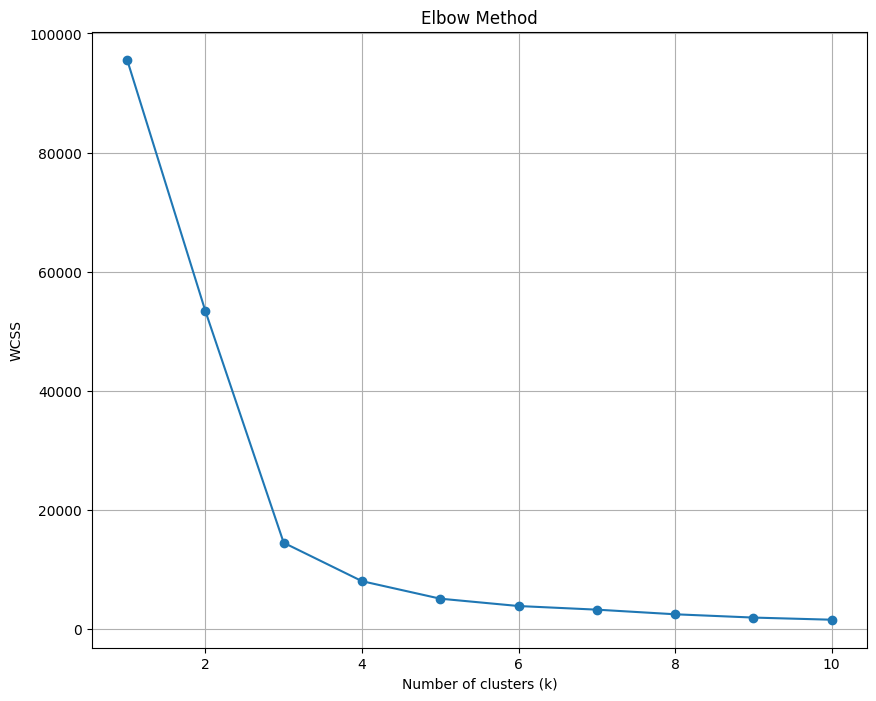

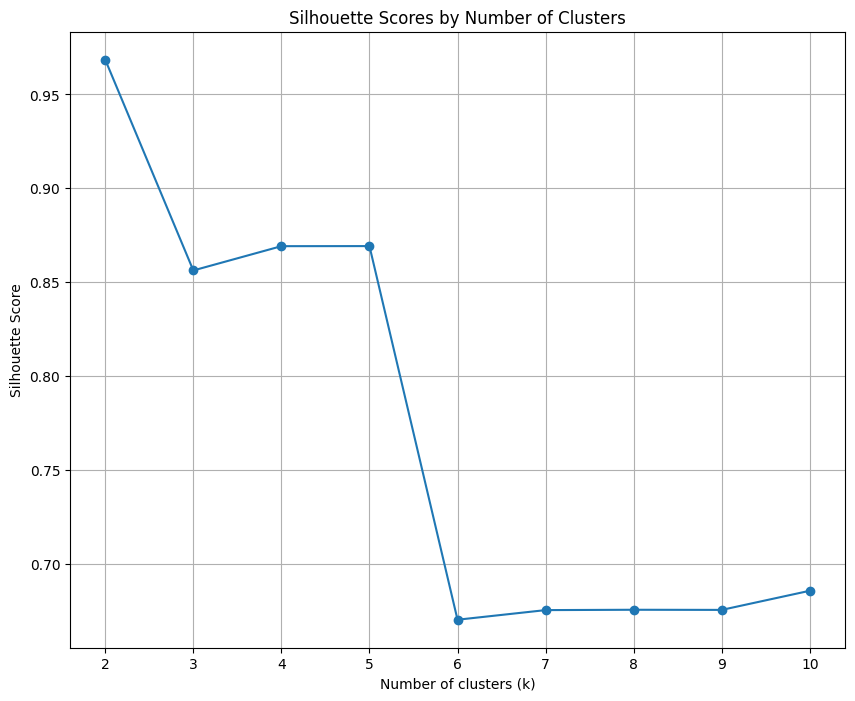

In [8]:
# Escalar los datos
columns_to_scale = ['ORIGINAL GROSS AMT', 'TRANS CAC DESC 1 Encoded']
data_scaled = scale_data(df_merged_cleaned, columns_to_scale)

# Calcular WCSS y valores de silueta
wcss = calculate_wcss(data_scaled, max_clusters=10)
silhouette_scores = calculate_silhouette(data_scaled, max_clusters=10)

# Graficar el método del codo y los valores de silueta
plot_elbow(wcss)
plot_silhouette(silhouette_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
0    38415
1     8102
4     1228
2       40
3       10
Name: count, dtype: int64


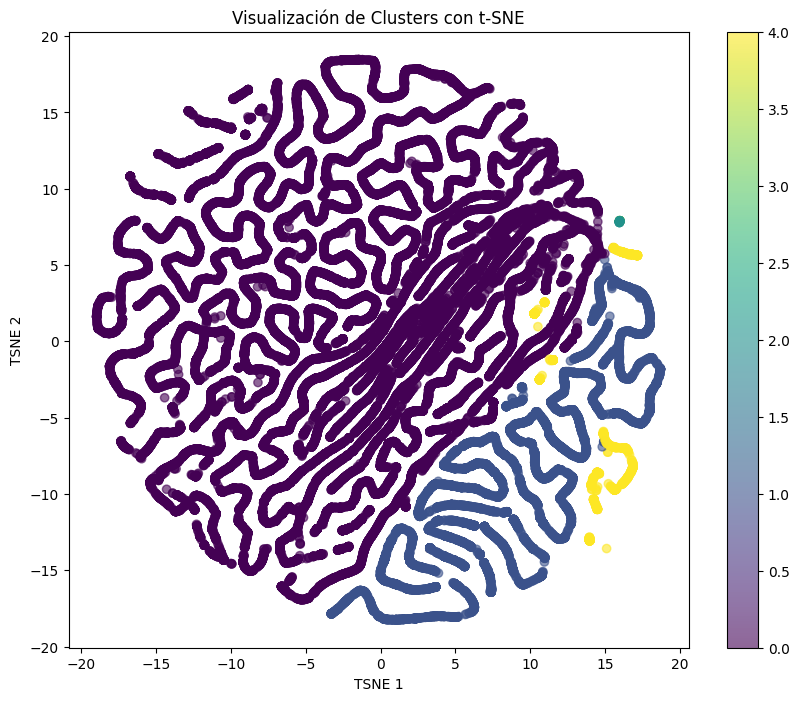

In [9]:
# Aquí, supongamos que determinamos que el mejor número de clusters es 5 basado en la gráfica
optimal_clusters = 5

# Aplicar K-means con el número óptimo de clusters
df_merged_cleaned['Cluster'] = apply_kmeans(data_scaled, n_clusters=optimal_clusters)

# Contar y visualizar los clusters
print(count_clusters(df_merged_cleaned['Cluster']))
visualize_clusters(data_scaled, df_merged_cleaned['Cluster'])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
1    38415
0     8102
3     1228
2       50
Name: count, dtype: int64


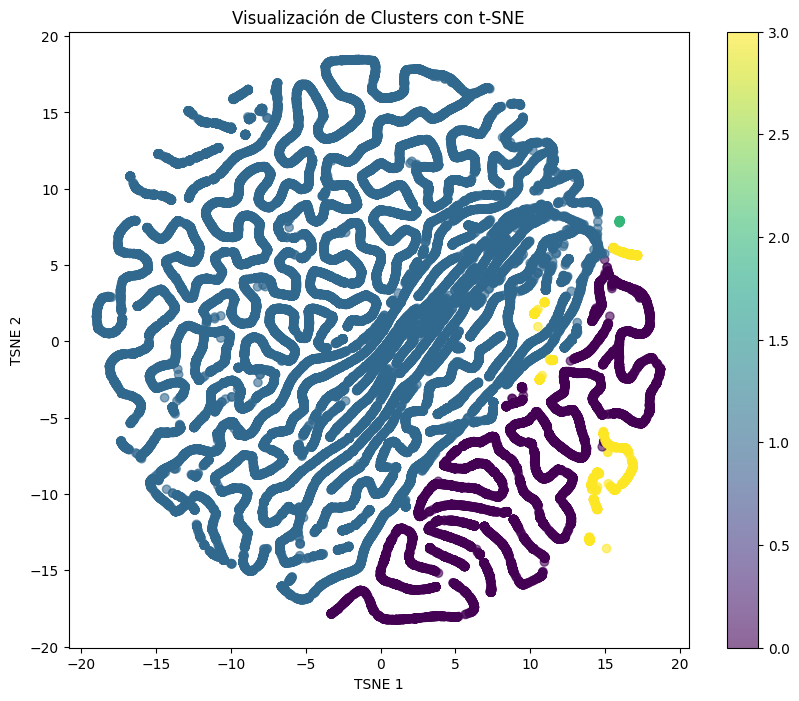

In [10]:
# Aquí, supongamos que determinamos que el mejor número de clusters es 5 basado en la gráfica
optimal_clusters = 4

# Aplicar K-means con el número óptimo de clusters
df_merged_cleaned['Cluster'] = apply_kmeans(data_scaled, n_clusters=optimal_clusters)

# Contar y visualizar los clusters
print(count_clusters(df_merged_cleaned['Cluster']))
visualize_clusters(data_scaled, df_merged_cleaned['Cluster'])


# Análisis de resultados del modelo

## Gasto total por cluster

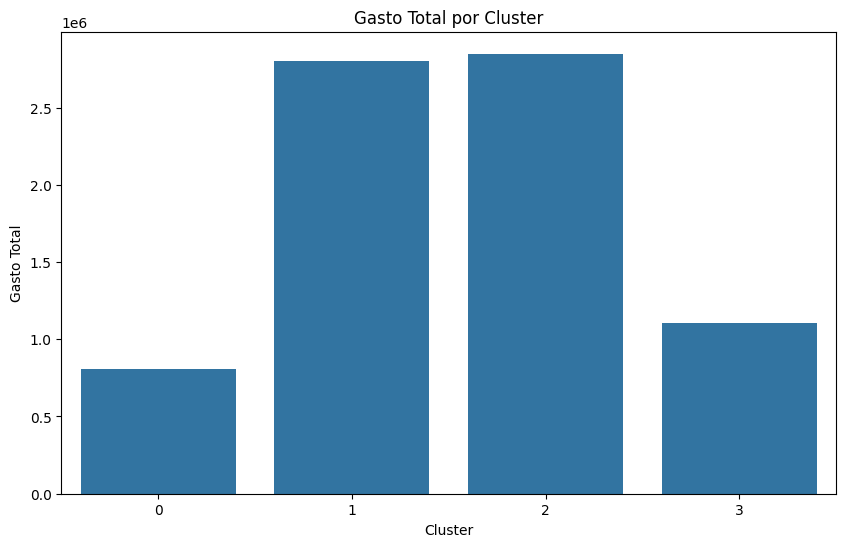

In [11]:

# Calcular el gasto total por cluster
gasto_total_por_cluster = df_merged_cleaned.groupby('Cluster')['ORIGINAL GROSS AMT'].sum().reset_index()

# Gráfico de barras para gasto total por cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='ORIGINAL GROSS AMT', data=gasto_total_por_cluster)

plt.title('Gasto Total por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gasto Total')
plt.show()


## Frecuencia de Transacciones por Cluster

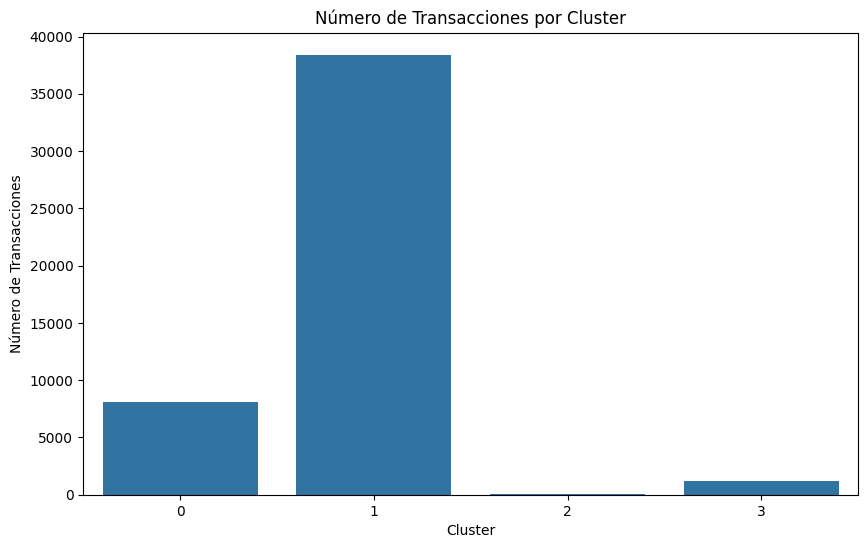

In [12]:
# Contar el número de transacciones por cluster
transacciones_por_cluster = df_merged_cleaned['Cluster'].value_counts().reset_index()
transacciones_por_cluster.columns = ['Cluster', 'Número de Transacciones']

# Gráfico de barras para el número de transacciones por cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Número de Transacciones', data=transacciones_por_cluster)
plt.title('Número de Transacciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Transacciones')
plt.show()

## Análisis Temporal del Gasto por Cluster

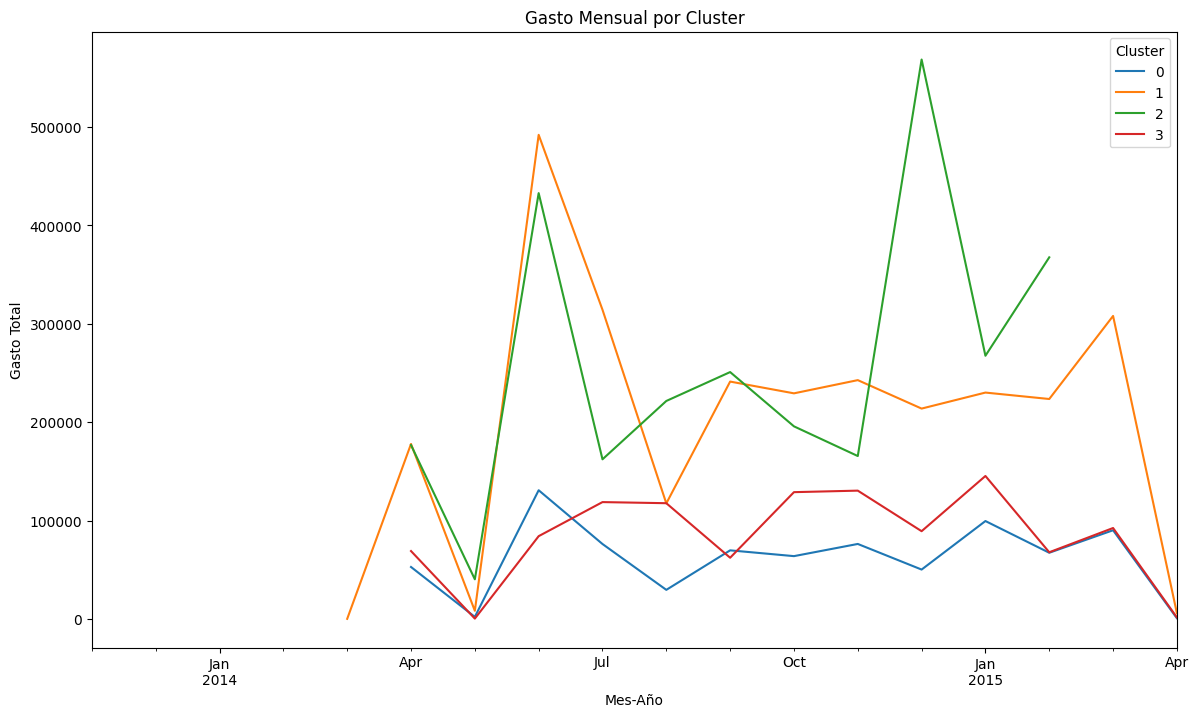

In [13]:
# Añadir una columna de mes-año para análisis temporal
df_merged_cleaned['Mes-Año'] = df_merged_cleaned['TRANS DATE'].dt.to_period('M')

# Sumar el gasto por mes y cluster
gasto_mensual_por_cluster = df_merged_cleaned.groupby(['Mes-Año', 'Cluster'])['ORIGINAL GROSS AMT'].sum().unstack()

# Gráfico de líneas para el gasto mensual por cluster
gasto_mensual_por_cluster.plot(figsize=(14, 8))
plt.title('Gasto Mensual por Cluster')
plt.xlabel('Mes-Año')
plt.ylabel('Gasto Total')
plt.legend(title='Cluster')
plt.show()


Parara el caso de k=4 se muestran varios picos en los que coinciden los cluster, siendo los más notorios los de abril de 2014, junio de 2014, diciembre  de 2014, sólo para el cluster número 2 y en marzo de 2015 para 3 de ellos, demostrando cierta estacionalidad aparente. Habría que meter más data al análisis para corroborar este fenómeno. Otro aspecto a analizar interesante sería comprobar si esta estacionalidad permaneció durante la época de la pandemia de COVID 19.

## Interacción con comerciantes Específicos

Es posible explorar los datos para identificar si ciertos comerciantes están asociados predominantemente con gastos altos o clusters específicos, lo cual podría ser útil para auditorías o revisiones de contratos y gastos.

In [14]:
# Agregar gasto total por comerciante y cluster
gasto_por_comerciante = df_merged_cleaned.groupby(['MERCHANT NAME', 'Cluster'])['ORIGINAL GROSS AMT'].sum().sort_values(ascending=False).reset_index()

# Mostrar los principales comerciantes por gasto total
print(gasto_por_comerciante.head(10))


              MERCHANT NAME  Cluster  ORIGINAL GROSS AMT
0    the furnishing service        2          2691199.69
1        civil justice cent        3           601375.00
2        hmcourts-service.g        3           332338.00
3      amazon mktplce eu-uk        1           121104.76
4  marriott hotel islamabad        2           106289.88
5                 amazon eu        1            78316.64
6       the hotel commingle        2            51200.00
7      amazon mktplce eu-uk        0            40484.19
8        drayton manor park        1            40208.45
9       post office counter        1            36972.68


#Evaluación del modelo

In [15]:
from sklearn.metrics import silhouette_score # en la última ejecución se usó el cluster = 4

# Calculando el índice de silueta
labels = df_merged_cleaned['Cluster']  # Este es el array de etiquetas de cluster
score = silhouette_score(data_scaled, labels)
print("Silhouette Score: ", score)


Silhouette Score:  0.869160308733048


Para k = 5 se obtuvi un índice de silueta de 0.8692, mientras que para k = 4 fue de 0.8691. Ambos son muy buenos y la elección de uno u otro en este caso es indistinta, y sugieren lo siguiente:

Alta Cohesión Interna: Los puntos dentro de cada cluster están muy cerca entre sí, lo que indica una alta cohesión. Esto significa que las características usadas para formar los clusters son efectivas para agrupar los datos en grupos similares.

Buena Separación entre Clusters: La distancia entre los clusters es significativa, lo que implica que cada cluster se distingue bien de los otros. Esto es un indicativo de que el modelo ha identificado patrones distintos en el conjunto de datos que son útiles para diferenciar entre tipos de transacciones, comportamientos de gasto, etc.